Training GRU model...
Epoch 1/20, Loss: 1.4297659397125244, Val Loss: 0.9885141253471375, Val Accuracy: 65.11%
Epoch 2/20, Loss: 0.9832572340965271, Val Loss: 0.7529507875442505, Val Accuracy: 73.53%
Epoch 3/20, Loss: 0.7490748167037964, Val Loss: 0.6141517162322998, Val Accuracy: 80.04%
Epoch 4/20, Loss: 0.6427882313728333, Val Loss: 0.5225412845611572, Val Accuracy: 82.88%
Epoch 5/20, Loss: 0.5222686529159546, Val Loss: 0.4854199290275574, Val Accuracy: 82.88%
Epoch 6/20, Loss: 0.45715951919555664, Val Loss: 0.4156489968299866, Val Accuracy: 85.81%
Epoch 7/20, Loss: 0.3877560496330261, Val Loss: 0.37833961844444275, Val Accuracy: 86.90%
Epoch 8/20, Loss: 0.34799495339393616, Val Loss: 0.3536251187324524, Val Accuracy: 87.00%
Epoch 9/20, Loss: 0.31560713052749634, Val Loss: 0.3358061611652374, Val Accuracy: 88.00%
Epoch 10/20, Loss: 0.28531280159950256, Val Loss: 0.3205629885196686, Val Accuracy: 88.19%
Epoch 11/20, Loss: 0.25552311539649963, Val Loss: 0.3020268380641937, Val Accuracy

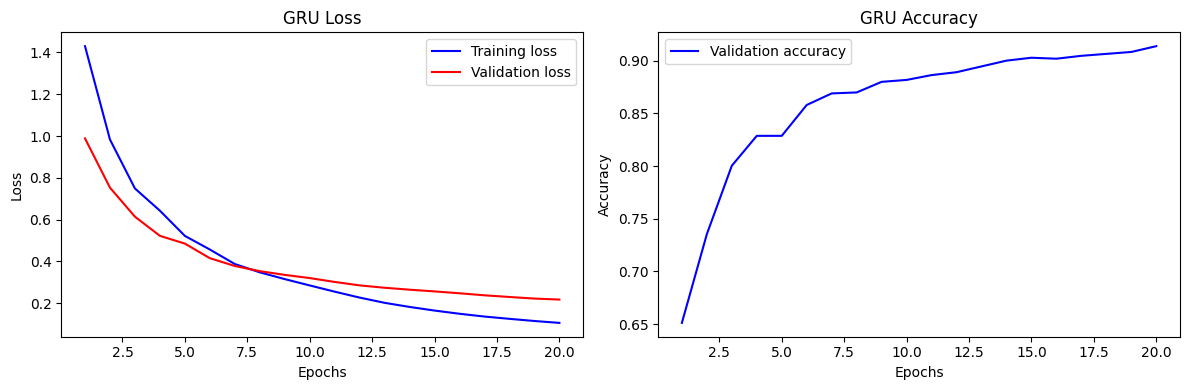

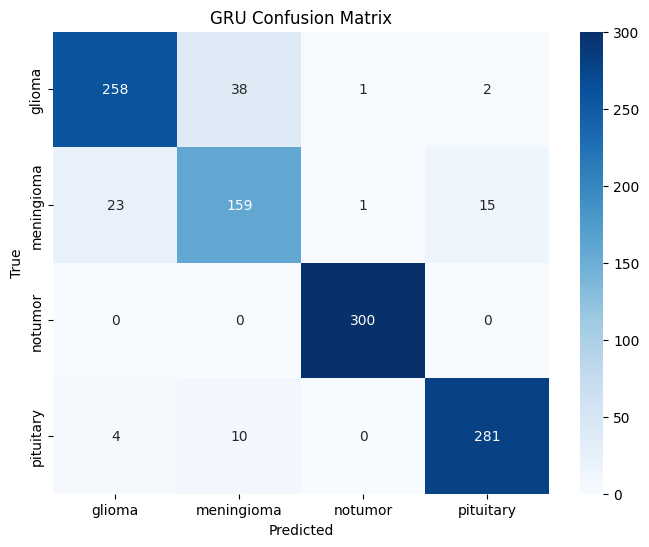

Training LSTM model...
Epoch 1/20, Loss: 1.4021267890930176, Val Loss: 1.0775601863861084, Val Accuracy: 62.09%
Epoch 2/20, Loss: 1.0834721326828003, Val Loss: 0.9292707443237305, Val Accuracy: 61.63%
Epoch 3/20, Loss: 0.9284512400627136, Val Loss: 0.7206315994262695, Val Accuracy: 82.23%
Epoch 4/20, Loss: 0.7450845837593079, Val Loss: 0.6472398042678833, Val Accuracy: 80.49%
Epoch 5/20, Loss: 0.650459885597229, Val Loss: 0.5757558345794678, Val Accuracy: 82.78%
Epoch 6/20, Loss: 0.5685784220695496, Val Loss: 0.5021113157272339, Val Accuracy: 85.07%
Epoch 7/20, Loss: 0.4931807518005371, Val Loss: 0.44907987117767334, Val Accuracy: 86.72%
Epoch 8/20, Loss: 0.42791301012039185, Val Loss: 0.40561550855636597, Val Accuracy: 87.09%
Epoch 9/20, Loss: 0.3765941858291626, Val Loss: 0.37532177567481995, Val Accuracy: 87.45%
Epoch 10/20, Loss: 0.33255696296691895, Val Loss: 0.348021000623703, Val Accuracy: 88.64%
Epoch 11/20, Loss: 0.2981593608856201, Val Loss: 0.3274923264980316, Val Accuracy: 

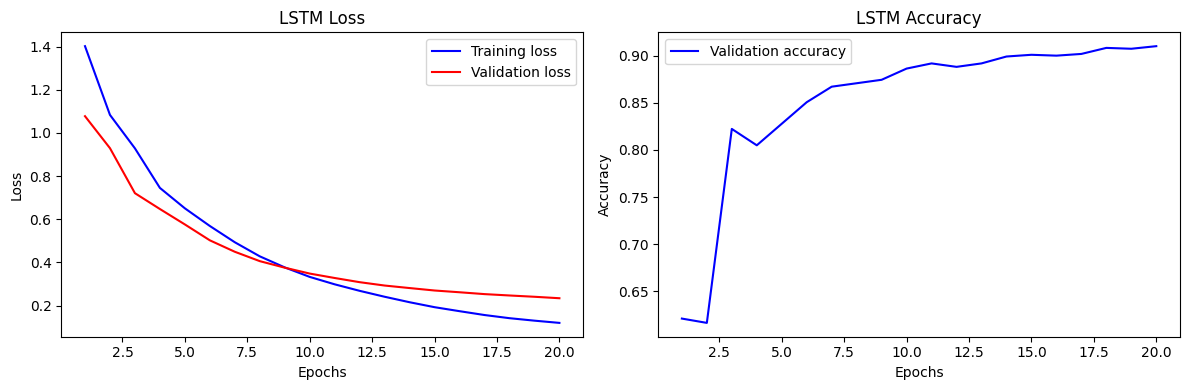

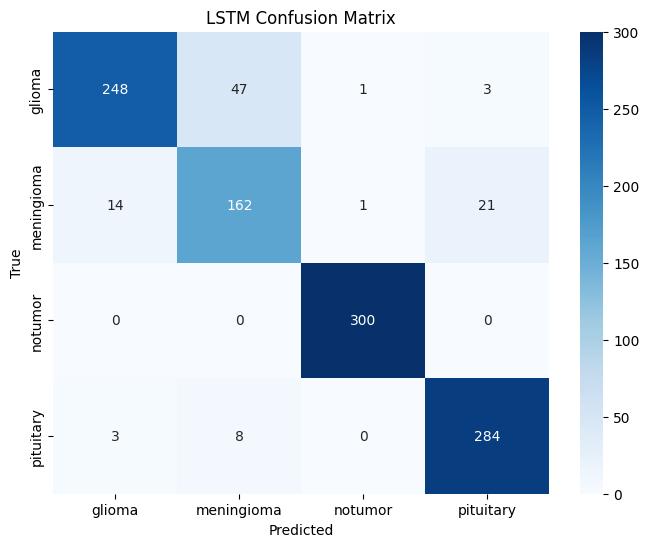

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths to your dataset
train_data_dir = 'cleaned/Training/'
validation_data_dir = 'cleaned/Testing/'

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load data
image_datasets = {
    'train': datasets.ImageFolder(train_data_dir, data_transforms['train']),
    'val': datasets.ImageFolder(validation_data_dir, data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=True)
}

# Load a pre-trained VGG16 model and extract features
class FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

# Update this line to use the new 'weights' parameter
pretrained_model = models.vgg16(weights='IMAGENET1K_V1')
feature_extractor = FeatureExtractor(pretrained_model).to("cuda")

# Freeze the pretrained model parameters
for param in feature_extractor.parameters():
    param.requires_grad = False

# Define a GRU model for classification
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Define an LSTM model for classification
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 128
			  
			 

# Instantiate the GRU and LSTM classifiers
			   
gru_classifier = GRUClassifier(input_size=512 * 7 * 7, hidden_size=hidden_size, num_classes=4).to(device)
lstm_classifier = LSTMClassifier(input_size=512 * 7 * 7, hidden_size=hidden_size, num_classes=4).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_classifier.parameters(), lr=0.005)
lstm_optimizer = optim.Adam(lstm_classifier.parameters(), lr=0.005)

# Function to extract features and labels from the data loader
def extract_features_and_labels(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Extract features for train and validation sets
train_features, train_labels = extract_features_and_labels(dataloaders['train'], feature_extractor)
val_features, val_labels = extract_features_and_labels(dataloaders['val'], feature_extractor)

# Convert features and labels to PyTorch tensors
train_features = torch.tensor(train_features).view(-1, 1, 512 * 7 * 7).to(device)
train_labels = torch.tensor(train_labels).long().to(device)  # Use long for CrossEntropyLoss
val_features = torch.tensor(val_features).view(-1, 1, 512 * 7 * 7).to(device)
val_labels = torch.tensor(val_labels).long().to(device)  # Use long for CrossEntropyLoss

# Training function
def train_model(model, optimizer, train_features, train_labels, val_features, val_labels, num_epochs=20):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_predictions = torch.argmax(val_outputs, dim=1).cpu().numpy()
        val_labels_np = val_labels.cpu().numpy()
        accuracy = accuracy_score(val_labels_np, val_predictions)
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {accuracy * 100:.2f}%')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features)
        val_predictions = torch.argmax(val_outputs, dim=1).cpu().numpy()
        val_labels_np = val_labels.cpu().numpy()
							  

        accuracy = accuracy_score(val_labels_np, val_predictions)
        precision = precision_score(val_labels_np, val_predictions, average='weighted')
        recall = recall_score(val_labels_np, val_predictions, average='weighted')
        f1 = f1_score(val_labels_np, val_predictions, average='weighted')
        conf_matrix = confusion_matrix(val_labels_np, val_predictions)
        
        return accuracy, precision, recall, f1, conf_matrix, train_losses, val_losses, val_accuracies

# Function to plot the training and validation losses and accuracy
def plot_metrics(train_losses, val_losses, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, model_name, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Train and evaluate GRU model
print("Training GRU model...")
gru_accuracy, gru_precision, gru_recall, gru_f1, gru_conf_matrix, gru_train_losses, gru_val_losses, gru_val_accuracies = train_model(gru_classifier, gru_optimizer, train_features, train_labels, val_features, val_labels, num_epochs=20)
print(f'GRU Validation Accuracy: {gru_accuracy * 100:.2f}%')
print(f'GRU Validation Precision: {gru_precision * 100:.2f}%')
print(f'GRU Validation Recall: {gru_recall * 100:.2f}%')
print(f'GRU Validation F1 Score: {gru_f1 * 100:.2f}%')

# Plot GRU metrics
plot_metrics(gru_train_losses, gru_val_losses, gru_val_accuracies, "GRU")
plot_confusion_matrix(gru_conf_matrix, "GRU", class_names=image_datasets['train'].classes)

# Train and evaluate LSTM model
print("Training LSTM model...")
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_conf_matrix, lstm_train_losses, lstm_val_losses, lstm_val_accuracies = train_model(lstm_classifier, lstm_optimizer, train_features, train_labels, val_features, val_labels, num_epochs=20)
print(f'LSTM Validation Accuracy: {lstm_accuracy * 100:.2f}%')
print(f'LSTM Validation Precision: {lstm_precision * 100:.2f}%')
print(f'LSTM Validation Recall: {lstm_recall * 100:.2f}%')
print(f'LSTM Validation F1 Score: {lstm_f1 * 100:.2f}%')

# Plot LSTM metrics
plot_metrics(lstm_train_losses, lstm_val_losses, lstm_val_accuracies, "LSTM")
plot_confusion_matrix(lstm_conf_matrix, "LSTM", class_names=image_datasets['train'].classes)
